# Step 5 - Grade, Subgrade, Interest Rate Modelling

## Goals in this Notebook

- Create a preprocessing pipeline or pipelines.
- Create a model for grade prediction.
- Create a model for subgrade prediction.
- Create a model for interest rate prediction.

The main metric to measure our models will be Mean Absolute Error (MAE). It is a common metric for continuos targets - an MAE of 0.5 would mean that on average predictions are 0.5 units away from the target. For grade and subgrade it may also be logical to use, since predicting B for an A grade loan is much better than predicting G for an A grade loan.

Thus, we will establish these goals for our models:
- 0.5 MAE for grade.
- 2.5 MAE for subgrade.
- 2.5 MAE for interest rate.

## Initialisation

### Imports

In [1]:
import os
import polars as pl
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import functions
import constants
from sklearn.metrics import (
    confusion_matrix,
    ConfusionMatrixDisplay,
    mean_squared_error,
    mean_absolute_error,
)
from sklearn.preprocessing import (
    TargetEncoder,
    OneHotEncoder,
    FunctionTransformer,
    OrdinalEncoder,
)
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import LinearRegression
from imblearn.under_sampling import RandomUnderSampler
import numpy as np
import xgboost as xgb
import pickle
import joblib
from joblib import dump

sns.set_palette("colorblind", 10)

### Data Preparation

In [2]:
acc_train_path = os.path.join("data", "acc_train.parquet")
df_acc = pl.read_parquet(acc_train_path)

excel_path = os.path.join("data", "acc_features.xlsx")
excel_to_drop = functions.get_excel_drop_features(excel_path)

df_acc = (
    df_acc.drop(excel_to_drop)
    .drop(constants.high_corr_to_drop)
    .drop(constants.boruta_to_drop)
    .pipe(functions.cast_wrong_str, cols=constants.wrong_str_to_cast_selected)
    # even though it's a good feature, it may not be logical to use it for future loans
    .drop("id")
)

In [3]:
df_acc.is_duplicated().sum()

0

After dropping all the features, there's still no duplicated entries.

## Preprocessor

In [4]:
binary_pipe = OneHotEncoder(
    drop="if_binary", handle_unknown="ignore", sparse_output=False
)

high_cardinal_pipe = TargetEncoder(target_type="continuous", shuffle=False)

verification_cols = ["verification_status"]
verification_order = [constants.verification_order]
verification_pipe = OrdinalEncoder(
    categories=verification_order,
    handle_unknown="use_encoded_value",
    unknown_value=np.nan,
)

home_own_cols = ["home_ownership"]
MAX_CAT = 3
home_own_pipe = OneHotEncoder(
    max_categories=MAX_CAT, handle_unknown="ignore", sparse_output=False
)

year_cols = ["earliest_cr_line"]

year_pipe = FunctionTransformer(
    functions.extract_year,
    validate=False,
    feature_names_out=functions.year_pipe_names_out,
)

binary_cols = constants.binary_cols_selected
high_cardinal_cols = constants.high_cardinal_cols_selected
not_numeric_cols = (
    constants.target_cols
    + binary_cols
    + high_cardinal_cols
    + verification_cols
    + home_own_cols
    + year_cols
)
numeric_cols = [col for col in df_acc.columns if col not in not_numeric_cols]

preprocessor_transformers = ColumnTransformer(
    [
        ("numeric_pipe", "passthrough", numeric_cols),
        ("binary_pipe", binary_pipe, binary_cols),
        ("high_cardinal_pipe", high_cardinal_pipe, high_cardinal_cols),
        ("verification_pipe", verification_pipe, verification_cols),
        ("home_own_pipe", home_own_pipe, home_own_cols),
        ("year_pipe", year_pipe, year_cols),
    ],
    verbose_feature_names_out=False,
).set_output(transform="pandas")

preprocessor_dropper = ColumnTransformer(
    [("drop", "drop", constants.to_drop_in_pipe)],
    verbose_feature_names_out=False,
    remainder="passthrough",
).set_output(transform="pandas")

preprocessor = Pipeline(
    [("transformers", preprocessor_transformers), ("dropper", preprocessor_dropper)]
)

### Testing Pipes

In [5]:
df_acc_sample = df_acc.sample(100_000, seed=42)

In [6]:
pipe_to_test = binary_pipe

X = df_acc_sample.select(binary_cols).to_pandas()
X_tf = pipe_to_test.fit_transform(X)
X_tf_df = pd.DataFrame(X_tf, columns=pipe_to_test.get_feature_names_out())
X_tf_df.head(2)

,initial_list_status_w,disbursement_method_DirectPay,term_ 60 months
0,0.0,0.0,0.0
1,1.0,0.0,0.0


In [7]:
pipe_to_test = high_cardinal_pipe

X = df_acc_sample.select(high_cardinal_cols).to_pandas()
y = df_acc_sample.select("int_rate").to_pandas()["int_rate"]
X_tf = pipe_to_test.fit_transform(X, y)
X_tf_df = pd.DataFrame(X_tf, columns=pipe_to_test.get_feature_names_out())
X_tf_df.head(2)

,purpose,title
0,13.517937,13.436201
1,11.746400,11.601673


In [8]:
pipe_to_test = verification_pipe

X = df_acc_sample.select(verification_cols).to_pandas().fillna(np.nan)
X_tf = pipe_to_test.fit_transform(X)
X_tf_df = pd.DataFrame(X_tf, columns=pipe_to_test.get_feature_names_out())
X_tf_df.describe()

,verification_status
count,100000.00000
mean,1.06601
std,0.84399
min,0.00000
25%,0.00000
50%,1.00000
75%,2.00000
max,2.00000


In [9]:
pipe_to_test = home_own_pipe

X = df_acc_sample.select(home_own_cols).to_pandas()
X_tf = pipe_to_test.fit_transform(X)
X_tf_df = pd.DataFrame(X_tf, columns=pipe_to_test.get_feature_names_out())
X_tf_df.head(2)

,home_ownership_MORTGAGE,home_ownership_RENT,home_ownership_infrequent_sklearn
0,1.0,0.0,0.0
1,1.0,0.0,0.0


In [10]:
pipe_to_test = year_pipe

X = df_acc_sample.select(year_cols).to_pandas()
X_tf = pipe_to_test.fit_transform(X)
X_tf_df = pd.DataFrame(X_tf, columns=pipe_to_test.get_feature_names_out())
X_tf_df.head(2)

,earliest_cr_line
0,1997
1,1988


## Grade Modelling

### Stratified Sample

#### Split Data for Modelling

Sample with stratification 3% of the data, 62k rows in total. The general idea would be to tune our models with a sample of the dataset, and then draw a very big sample or fit to all the data.

Due to time limitations, I will be using a sample for the whole remainder of the project.

In [11]:
df_acc_sample, _ = train_test_split(
    df_acc,
    test_size=0.97,
    stratify=df_acc.select("grade"),
    shuffle=True,
    random_state=42,
)
df_acc_sample.shape

(62085, 71)

20% into validation, do a X/y split and transform using preprocessor.

In [12]:
df_acc_sample_train, df_acc_sample_valid = train_test_split(
    df_acc_sample, test_size=0.2, stratify=df_acc_sample.select("grade")
)

X_train = df_acc_sample_train.drop(constants.target_cols).to_pandas()
y_train = df_acc_sample_train.select("grade")
y_train = functions.encode_ordinal_col_polars(y_train, "grade", constants.grade_order)
int_rate_train = df_acc_sample_train.select("int_rate").to_pandas()["int_rate"]

X_valid = df_acc_sample_valid.drop(constants.target_cols).to_pandas()
y_valid = df_acc_sample_valid.select("grade")
y_valid = functions.encode_ordinal_col_polars(y_valid, "grade", constants.grade_order)

X_train_tf = preprocessor.fit_transform(X_train, int_rate_train)
X_valid_tf = preprocessor.transform(X_valid)

In [13]:
dump(preprocessor, "models/grade_preprocessor_V1.joblib")

['models/grade_preprocessor_V1.joblib']

#### Random Forest Baseline

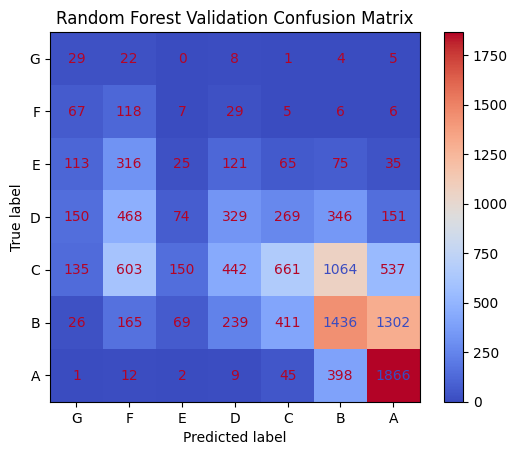

              precision    recall  f1-score   support

         0.0       0.42      0.06      0.10       521
         1.0       0.50      0.07      0.12      1704
         2.0       0.03      0.08      0.05       327
         3.0       0.18      0.28      0.22      1177
         4.0       0.18      0.45      0.26      1457
         5.0       0.39      0.43      0.41      3329
         6.0       0.80      0.48      0.60      3902

    accuracy                           0.36     12417
   macro avg       0.36      0.26      0.25     12417
weighted avg       0.48      0.36      0.37     12417

RMSE: 1.529
MAE: 1.074


In [14]:
forest = RandomForestClassifier(
    max_depth=6, n_jobs=-1, class_weight="balanced", random_state=42
)
X_train_tf_rf = X_train_tf.fillna(-100_000_000)
X_valid_tf_rf = X_valid_tf.fillna(-100_000_000)

forest.fit(X_train_tf_rf, y_train.to_pandas()["grade_encoded"])
y_pred = forest.predict(X_valid_tf_rf)

conf_mx = confusion_matrix(y_valid.to_series(), y_pred)
disp_rf = ConfusionMatrixDisplay(
    confusion_matrix=conf_mx, display_labels=constants.grade_order
)
functions.print_grade_metrics(
    disp_rf, y_valid.to_numpy(), y_pred, "Random Forest Validation Confusion Matrix"
)
mae = mean_absolute_error(y_valid.to_numpy(), y_pred)
grade_metrics = {"Random Forest": mae}

#### XGBoost

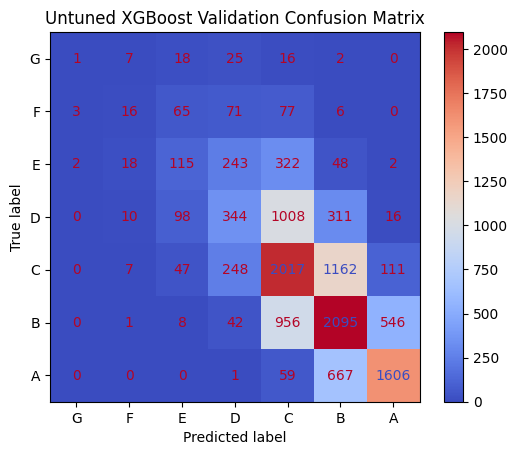

              precision    recall  f1-score   support

           0       0.01      0.17      0.03         6
           1       0.07      0.27      0.11        59
           2       0.15      0.33      0.21       351
           3       0.19      0.35      0.25       974
           4       0.56      0.45      0.50      4455
           5       0.57      0.49      0.53      4291
           6       0.69      0.70      0.70      2281

    accuracy                           0.50     12417
   macro avg       0.32      0.39      0.33     12417
weighted avg       0.55      0.50      0.52     12417

RMSE: 0.945
MAE: 0.617


In [15]:
model = xgb.XGBClassifier(
    objective="multi:softprob",
    n_estimators=500,
    learning_rate=0.15,
    early_stopping_rounds=50,
    seed=42,
    random_state=42,
)
model.fit(
    X_train_tf,
    y_train,
    eval_set=[(X_valid_tf, y_valid)],
    verbose=0,
)

y_pred = model.predict(X_valid_tf)
conf_mx = confusion_matrix(y_valid.to_series(), y_pred)
disp_xgb1 = ConfusionMatrixDisplay(
    confusion_matrix=conf_mx, display_labels=constants.grade_order
)
functions.print_grade_metrics(
    disp_xgb1, y_valid.to_numpy(), y_pred, "Untuned XGBoost Validation Confusion Matrix"
)
mae = mean_absolute_error(y_valid.to_numpy(), y_pred)
grade_metrics["Untuned XGBoost"] = mae

#### Tuning

Tuning runs for an hour, therefore I commented it out.

In [16]:
# optuna.logging.set_verbosity(optuna.logging.WARNING)

# def objective(trial):
#     xgb_params = dict(
#         max_depth=trial.suggest_int("max_depth", 2, 10),
#         learning_rate=trial.suggest_float("learning_rate", 0.05, 0.3, log=True),
#         gamma=trial.suggest_float("gamma", 1e-4, 5, log=True),
#         min_child_weight=trial.suggest_int("min_child_weight", 1, 10),
#         reg_alpha=trial.suggest_float("reg_alpha", 1e-4, 1e2, log=True),
#         reg_lambda=trial.suggest_float("reg_lambda", 1e-4, 1e2, log=True),
#         subsample=trial.suggest_float("subsample", 0.5, 1),
#         objective="multi:softprob",
#         n_estimators=1000,
#         early_stopping_rounds=20,
#         random_state=42,
#     )
#     model = xgb.XGBClassifier(**xgb_params)
#     model.fit(X_train_tf, y_train, eval_set=[(X_valid_tf, y_valid)], verbose=0)
#     return model.best_score

# sampler = optuna.samplers.TPESampler(seed=42)
# study = optuna.create_study(direction="minimize", sampler=sampler)
# study.optimize(objective, n_trials=50, n_jobs=-1)
# xgb_params = study.best_params
# with open("data/grade_xgbparams.pkl", 'wb') as file:
#     pickle.dump(xgb_params, file)

with open("data/grade_xgbparams.pkl", "rb") as file:
    xgb_params = pickle.load(file)

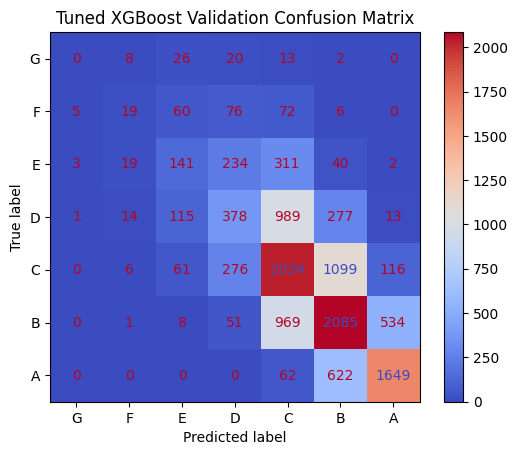

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         9
           1       0.08      0.28      0.12        67
           2       0.19      0.34      0.24       411
           3       0.21      0.37      0.27      1035
           4       0.57      0.46      0.51      4450
           5       0.57      0.50      0.54      4131
           6       0.71      0.71      0.71      2314

    accuracy                           0.51     12417
   macro avg       0.33      0.38      0.34     12417
weighted avg       0.55      0.51      0.52     12417

RMSE: 0.931
MAE: 0.604


In [17]:
model = xgb.XGBClassifier(
    objective="multi:softprob",
    n_estimators=1000,
    early_stopping_rounds=20,
    random_state=42,
    **xgb_params,
)
model.fit(
    X_train_tf,
    y_train,
    eval_set=[(X_train_tf, y_train), (X_valid_tf, y_valid)],
    verbose=0,
)

y_pred = model.predict(X_valid_tf)
conf_mx = confusion_matrix(y_valid.to_series(), y_pred)
disp_xgb2 = ConfusionMatrixDisplay(
    confusion_matrix=conf_mx, display_labels=constants.grade_order
)
functions.print_grade_metrics(
    disp_xgb2, y_valid.to_numpy(), y_pred, "Tuned XGBoost Validation Confusion Matrix"
)
mae = mean_absolute_error(y_valid.to_numpy(), y_pred)
grade_metrics["Tuned XGBoost"] = mae

In [18]:
dump(model, "models/grade_model_V1.joblib")

['models/grade_model_V1.joblib']

#### Summary

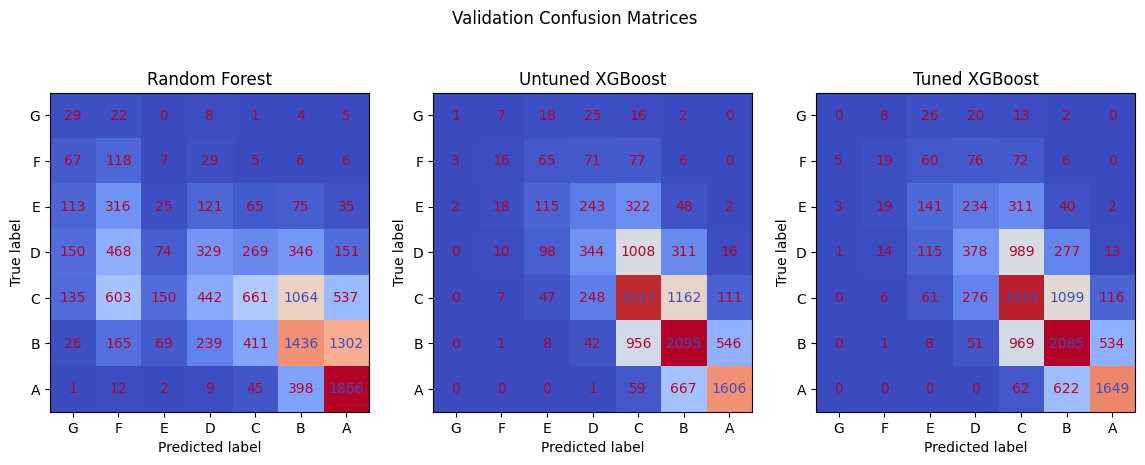

MAE of the grade models
----


Random Forest      1.074253
Untuned XGBoost    0.617138
Tuned XGBoost      0.604172
Name: MAE, dtype: float64

In [19]:
fig, ax = plt.subplots(1, 3)

disp_rf.plot(ax=ax[0], colorbar=False, cmap=functions.figure_colors_cmap)
ax[0].set_title("Random Forest")

disp_xgb1.plot(ax=ax[1], colorbar=False, cmap=functions.figure_colors_cmap)
ax[1].set_title("Untuned XGBoost")

disp_xgb2.plot(ax=ax[2], colorbar=False, cmap=functions.figure_colors_cmap)
ax[2].set_title("Tuned XGBoost")

fig.set_figheight(5)
fig.set_figwidth(14)
plt.suptitle("Validation Confusion Matrices")
plt.show()
print("MAE of the grade models\n----")
pd.Series(grade_metrics, name="MAE")

Just eyeing the confusion matrices it's quite clear that the random forest only performs well for G and A classes, other are spread out greatly. Xgboost does quite well for classes A,B,C but starts falling down after C. Using MAE metric is a good indicator here, as we also get the worst performance for random forest and best for tuned Xgboost. However, our tuned model falls a bit short of the required MAE (0.5)

#### Ideas to Improve

- Fit on the whole dataset.
- Is it possible to adjust the multiclass weights for prediction, giving more importance for lower grades?
- Sample the same amount of grades. ie 10k of G, F ... A each.
- Tune our model using MAE or RMSE.
- Use ordinal classification: first model checks if the grade is G or the rest, then second model checks if it's F or the rest and so on.
- Run regression - G is 0, F is 1 and so on.

### Sample the Same Amount of Grades (Downsample)

#### Split Data

1% stratified sample for validation, for training - downsampled dataset so that each class has the same occurrence as the most minor class.

I added a prefix "_dwn" to all data so that previous data split won't be overwritten - we'll use it again.

In [20]:
df_acc_sample_dwn, df_acc_sample_valid_dwn = train_test_split(
    df_acc,
    test_size=0.01,
    stratify=df_acc.select("grade"),
    shuffle=True,
    random_state=42,
)

sampler = RandomUnderSampler(random_state=42)
df_acc_sample_train_dwn, y_train_dwn = sampler.fit_resample(
    df_acc_sample_dwn.to_pandas(), df_acc_sample_dwn.select("grade").to_pandas()
)

X_train_dwn = df_acc_sample_train_dwn.drop(columns=constants.target_cols)
encoder = OrdinalEncoder(
    categories=[constants.grade_order],
    handle_unknown="use_encoded_value",
    unknown_value=np.nan,
)
encoded = encoder.fit_transform(y_train_dwn)
y_train_dwn = pd.Series(encoded.flatten(), name="grade_encoded")
int_rate_train_dwn = df_acc_sample_train_dwn["int_rate"]

X_valid_dwn = df_acc_sample_valid_dwn.drop(constants.target_cols).to_pandas()
y_valid_dwn = df_acc_sample_valid_dwn.select("grade")
y_valid_dwn = functions.encode_ordinal_col_polars(
    y_valid_dwn, "grade", constants.grade_order
)

X_train_tf_dwn = preprocessor.fit_transform(X_train_dwn, int_rate_train_dwn)
X_valid_tf_dwn = preprocessor.transform(X_valid_dwn)

#### Random Forest Baseline

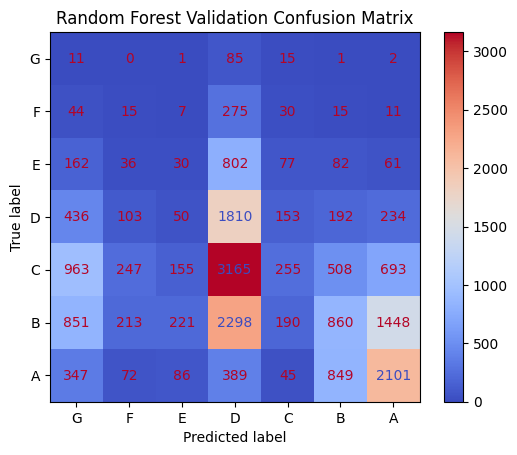

              precision    recall  f1-score   support

         0.0       0.10      0.00      0.01      2814
         1.0       0.04      0.02      0.03       686
         2.0       0.02      0.05      0.03       550
         3.0       0.61      0.21      0.31      8824
         4.0       0.04      0.33      0.08       765
         5.0       0.14      0.34      0.20      2507
         6.0       0.54      0.46      0.50      4550

    accuracy                           0.25     20696
   macro avg       0.21      0.20      0.16     20696
weighted avg       0.41      0.25      0.27     20696

RMSE: 2.158
MAE: 1.576


In [21]:
forest = RandomForestClassifier(max_depth=6, n_jobs=-1)
X_train_tf_rf_dwn = X_train_tf_dwn.fillna(-100_000_000)
forest.fit(X_train_tf_rf_dwn, y_train_dwn)

X_valid_tf_rf_dwn = X_valid_tf_dwn.fillna(-100_000_000)
y_pred_dwn = forest.predict(X_valid_tf_rf_dwn)
conf_mx = confusion_matrix(y_valid_dwn.to_series(), y_pred_dwn)
disp = ConfusionMatrixDisplay(
    confusion_matrix=conf_mx, display_labels=constants.grade_order
)
functions.print_grade_metrics(
    disp,
    y_valid_dwn.to_numpy(),
    y_pred_dwn,
    "Random Forest Validation Confusion Matrix",
)

#### XGBoost

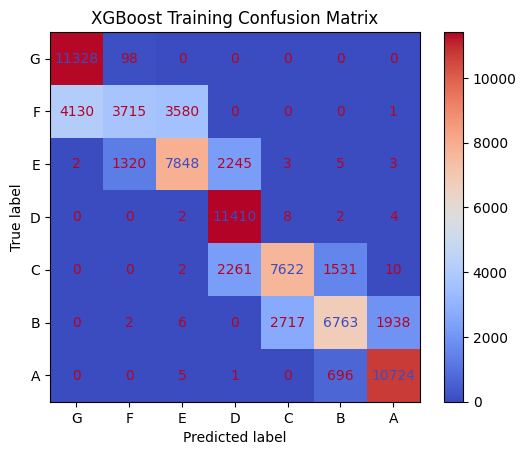

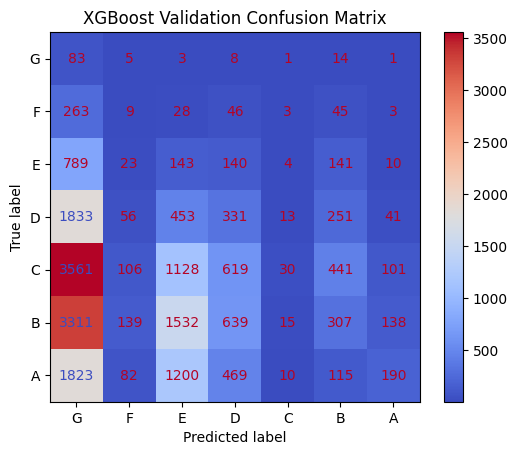

In [22]:
model = xgb.XGBClassifier(
    objective="multi:softprob",
    n_estimators=50,
    learning_rate=0.15,
    seed=42,
    random_state=42,
)
model.fit(
    X_train_tf_dwn,
    y_train_dwn,
    eval_set=[(X_valid_tf_dwn, y_valid_dwn)],
    verbose=0,
)

y_pred_dwn = model.predict(X_train_tf_dwn)
conf_mx = confusion_matrix(y_train_dwn, y_pred_dwn)
disp = ConfusionMatrixDisplay(
    confusion_matrix=conf_mx, display_labels=constants.grade_order
)
disp.plot(cmap=functions.figure_colors_cmap)
plt.title("XGBoost Training Confusion Matrix")
plt.show()

y_pred_dwn = model.predict(X_valid_tf_dwn)
conf_mx = confusion_matrix(y_valid_dwn, y_pred_dwn)
disp = ConfusionMatrixDisplay(
    confusion_matrix=conf_mx, display_labels=constants.grade_order
)
disp.plot(cmap=functions.figure_colors_cmap)
plt.title("XGBoost Validation Confusion Matrix")
plt.show()

When the XGBoost model is training on downsampled data but evaluating on stratified data, it does not improve at all. Perhaps tuning could help, but I feel that the time can be better spent elsewhere.

## Subgrade

#### Redefine y

We could re-stratify the data here based on subgrade instead of grade. However, we'll only redefine the target.

In [23]:
y_train = df_acc_sample_train.select("sub_grade")
y_train = functions.encode_ordinal_col_polars(
    y_train, "sub_grade", constants.subgrade_order
)

y_valid = df_acc_sample_valid.select("sub_grade")
y_valid = functions.encode_ordinal_col_polars(
    y_valid, "sub_grade", constants.subgrade_order
)

I save the preprocessor again here if in the future the code will be updated to have different preprocessors.

In [24]:
dump(preprocessor, "models/subgrade_preprocessor_V1.joblib")

['models/subgrade_preprocessor_V1.joblib']

#### Random Forest Baseline

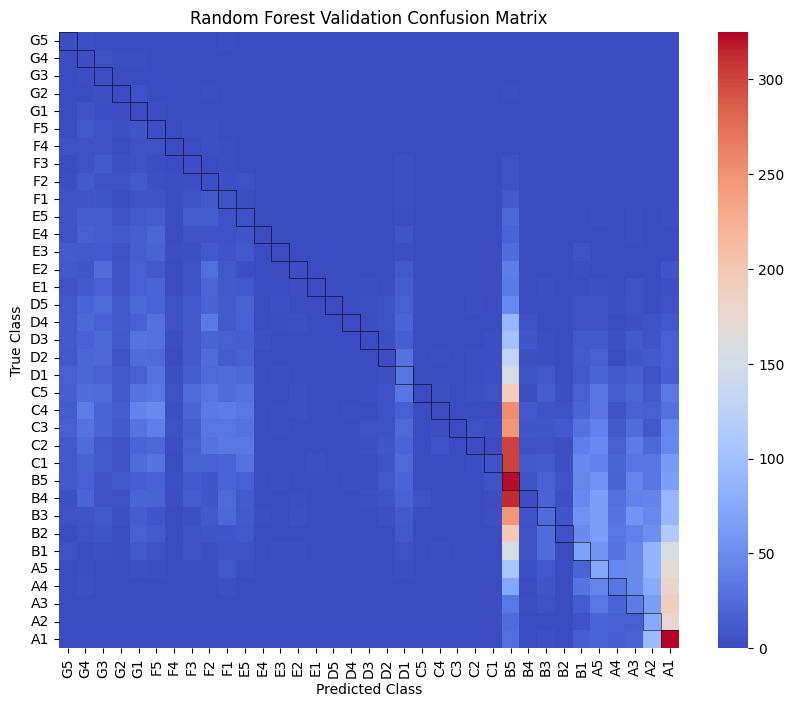

RMSE: 9.071
MAE: 6.742


In [25]:
forest = RandomForestClassifier(max_depth=6, n_jobs=-1, class_weight="balanced")

forest.fit(X_train_tf_rf, y_train.to_pandas()["sub_grade_encoded"])
y_pred = forest.predict(X_valid_tf_rf)

conf_mx = confusion_matrix(y_valid.to_series(), y_pred)
functions.print_subgrade_metrics(
    conf_mx, y_valid.to_numpy(), y_pred, "Random Forest Validation Confusion Matrix"
)

Clearly, this simple baseline lacks the complexity to model the output correctly.

#### XGBoost

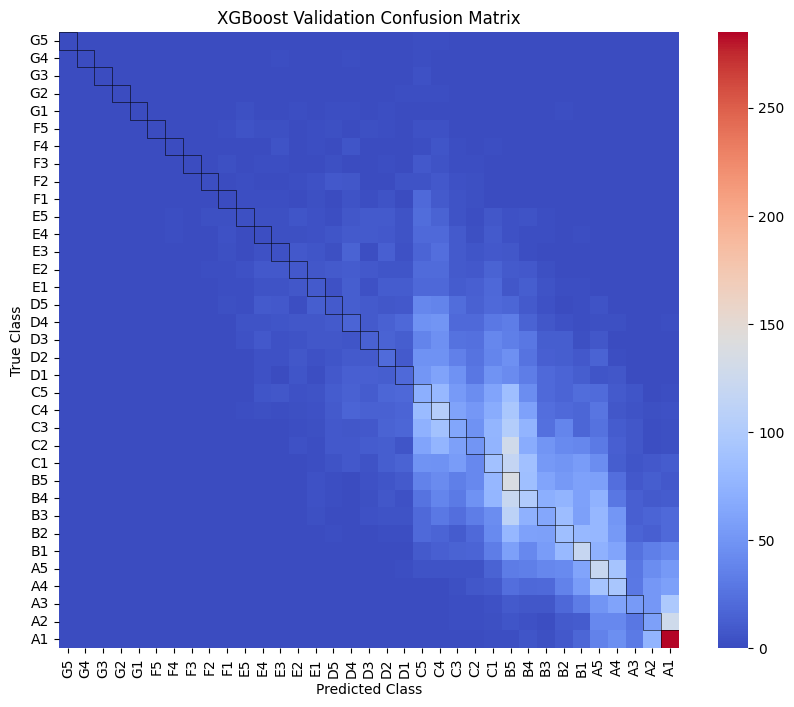

RMSE: 4.897
MAE: 3.597


In [26]:
model = xgb.XGBClassifier(
    objective="multi:softprob",
    n_estimators=500,
    learning_rate=0.15,
    early_stopping_rounds=50,
    seed=42,
    random_state=42,
)
model.fit(
    X_train_tf,
    y_train,
    eval_set=[(X_valid_tf, y_valid)],
    verbose=0,
)

y_pred = model.predict(X_valid_tf)
conf_mx = confusion_matrix(y_valid.to_series(), y_pred)
functions.print_subgrade_metrics(
    conf_mx, y_valid.to_numpy(), y_pred, "XGBoost Validation Confusion Matrix"
)

XGBoost performs a lot better, but still we are on average 3.6 subgrades away from the reality. We didn't achieve 2.5 MAE, but tuning and fitting on the whole dataset could get us there.

Here, tuning should take place. More importantly, we would want to fit the model to the whole dataset. I am skipping these steps due to time limitations.

In [27]:
dump(model, "models/subgrade_model_V1.joblib")

['models/subgrade_model_V1.joblib']

## Interest Rate

#### Redefine y

In [28]:
y_train = df_acc_sample_train.select("int_rate")
y_valid = df_acc_sample_valid.select("int_rate")

In [29]:
dump(preprocessor, "models/int_rate_preprocessor_V1.joblib")

['models/int_rate_preprocessor_V1.joblib']

#### Random Forest Baseline

In [30]:
forest = RandomForestRegressor(max_depth=6, n_jobs=-1)

forest.fit(X_train_tf_rf, y_train.to_pandas()["int_rate"])
y_pred = forest.predict(X_valid_tf_rf)

rmse = mean_squared_error(y_valid.to_numpy(), y_pred, squared=False)
mae = mean_absolute_error(y_valid.to_numpy(), y_pred)
print(f"RMSE: {rmse:2.3f}")
print(f"MAE: {mae:2.3f}")

RMSE: 3.701
MAE: 2.810


#### XGBoost

In [31]:
model = xgb.XGBRegressor(
    objective="reg:squarederror",
    n_estimators=500,
    learning_rate=0.15,
    early_stopping_rounds=50,
    seed=42,
    random_state=42,
)
model.fit(
    X_train_tf,
    y_train,
    eval_set=[(X_valid_tf, y_valid)],
    verbose=0,
)

y_pred = model.predict(X_valid_tf)
rmse = mean_squared_error(y_valid.to_numpy(), y_pred, squared=False)
mae = mean_absolute_error(y_valid.to_numpy(), y_pred)
print(f"RMSE: {rmse:2.3f}")
print(f"MAE: {mae:2.3f}")

RMSE: 3.178
MAE: 2.373


Better than the baseline!

#### Tuning

In [32]:
# optuna.logging.set_verbosity(optuna.logging.WARNING)

# def objective(trial):
#     xgb_params = dict(
#         max_depth=trial.suggest_int("max_depth", 2, 10),
#         learning_rate=trial.suggest_float("learning_rate", 0.05, 0.3, log=True),
#         gamma=trial.suggest_float("gamma", 1e-4, 5, log=True),
#         min_child_weight=trial.suggest_int("min_child_weight", 1, 10),
#         reg_alpha=trial.suggest_float("reg_alpha", 1e-4, 1e2, log=True),
#         reg_lambda=trial.suggest_float("reg_lambda", 1e-4, 1e2, log=True),
#         subsample=trial.suggest_float("subsample", 0.5, 1),
#         objective="reg:squarederror",
#         n_estimators=1000,
#         early_stopping_rounds=20,
#         random_state=42,
#     )
#     model = xgb.XGBRegressor(**xgb_params)
#     model.fit(X_train_tf, y_train, eval_set=[(X_valid_tf, y_valid)], verbose=0)
#     return model.best_score

# sampler = optuna.samplers.TPESampler(seed=42)
# study = optuna.create_study(direction="minimize", sampler=sampler)
# study.optimize(objective, n_trials=50, n_jobs=-1)
# xgb_params = study.best_params

# with open("data/int_rate_xgbparams.pkl", 'wb') as file:
#     pickle.dump(xgb_params, file)

with open("data/int_rate_xgbparams.pkl", "rb") as file:
    xgb_params = pickle.load(file)

In [37]:
model = xgb.XGBRegressor(
    objective="reg:squarederror",
    n_estimators=1000,
    early_stopping_rounds=20,
    seed=42,
    random_state=42,
    **xgb_params,
)
model.fit(
    X_train_tf,
    y_train,
    eval_set=[(X_valid_tf, y_valid)],
    verbose=0,
)

y_pred = model.predict(X_valid_tf)
rmse = mean_squared_error(y_valid.to_numpy(), y_pred, squared=False)
mae = mean_absolute_error(y_valid.to_numpy(), y_pred)
print(f"RMSE: {rmse:2.3f}")
print(f"MAE: {mae:2.3f}")

RMSE: 3.122
MAE: 2.335


Better than before tuning, but still we are 2.3% away from the real interest rate on average. However, we broke our target MAE - 2.5.

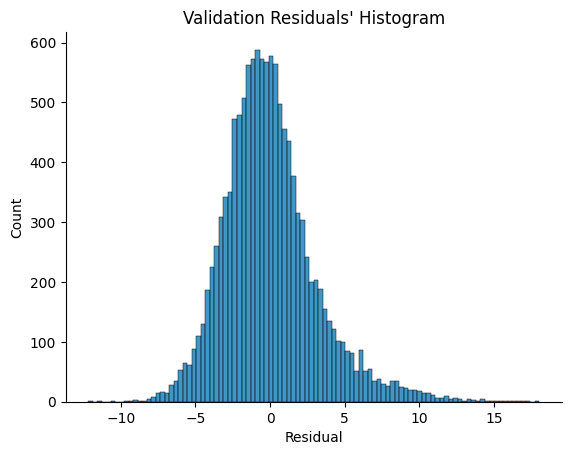

In [34]:
residuals = y_valid.to_numpy().flatten() - y_pred
sns.histplot(residuals)
plt.title("Validation Residuals' Histogram")
plt.xlabel("Residual")
sns.despine()

The residuals of the validation set seem normal enough, there's only a slight skew, as we are struggling to predict the lower grade loans.

In [36]:
print("Validation target stats")
int_rates = y_valid.to_numpy().flatten()
pd.Series(int_rates).describe()

Validation target stats


count    12417.000000
mean        13.109898
std          4.841987
min          5.310000
25%          9.670000
50%         12.690000
75%         15.880000
max         30.990000
dtype: float64

In [36]:
print("Predictions' stats")
pd.Series(y_pred.flatten()).describe()

Predictions' stats


count    12417.000000
mean        13.070595
std          3.676577
min          3.680726
25%         10.462813
50%         13.002800
75%         15.498326
max         28.044579
dtype: float64

Our model's predictions have a different distribution. However, the means are similar, so on average the predictions even out.

In [37]:
dump(model, "models/int_rate_model_V1.joblib")

['models/int_rate_model_V1.joblib']

#### Interest Rate from Grade or Subgrade

Aim - to use a linear regression to predict interest rate using grade/subgrade as inputs.

In [38]:
# record MAE metrics for comparison, starting with latest XGBoost
regressor_metrics = {"XGBoost": mae}

grade_model = joblib.load("models/grade_model_V1.joblib")
regressor = LinearRegression()
reg_x_train = df_acc_sample_train.select("grade")
reg_x_train = functions.encode_ordinal_col_polars(
    reg_x_train, "grade", constants.grade_order
)
reg_x_valid = grade_model.predict(X_valid_tf)

regressor.fit(reg_x_train.to_numpy(), y_train.to_numpy())
y_pred = regressor.predict(reg_x_valid.reshape(1, -1).T)

rmse = mean_squared_error(y_valid.to_numpy(), y_pred, squared=False)
mae = mean_absolute_error(y_valid.to_numpy(), y_pred)
regressor_metrics["grade, trained on true X"] = mae
print("Model trained on actual grade data, validated as a pipeline of to models\n-----")
print(f"RMSE: {rmse:2.3f}")
print(f"MAE: {mae:2.3f}")

Model trained on actual grade data, validated as a pipeline of to models
-----
RMSE: 3.561
MAE: 2.606


In [39]:
reg_x_train = grade_model.predict(X_train_tf)

regressor.fit(reg_x_train.reshape(1, -1).T, y_train.to_numpy())
y_pred = regressor.predict(reg_x_valid.reshape(1, -1).T)

rmse = mean_squared_error(y_valid.to_numpy(), y_pred, squared=False)
mae = mean_absolute_error(y_valid.to_numpy(), y_pred)
regressor_metrics["grade, trained on pred X"] = mae
print("Model trained and validated on predicted grade\n-----")
print(f"RMSE: {rmse:2.3f}")
print(f"MAE: {mae:2.3f}")

Model trained and validated on predicted grade
-----
RMSE: 3.458
MAE: 2.586


In [40]:
subgrade_model = joblib.load("models/subgrade_model_V1.joblib")
regressor = LinearRegression()
reg_x_train = df_acc_sample_train.select("sub_grade")
reg_x_train = functions.encode_ordinal_col_polars(
    reg_x_train, "sub_grade", constants.subgrade_order
)
reg_x_valid = subgrade_model.predict(X_valid_tf)

regressor.fit(reg_x_train.to_numpy(), y_train.to_numpy())
y_pred = regressor.predict(reg_x_valid.reshape(1, -1).T)

rmse = mean_squared_error(y_valid.to_numpy(), y_pred, squared=False)
mae = mean_absolute_error(y_valid.to_numpy(), y_pred)
regressor_metrics["subgrade, trained on true X"] = mae
print(
    "Model trained on actual subgrade data, validated as a pipeline of to models\n-----"
)
print(f"RMSE: {rmse:2.3f}")
print(f"MAE: {mae:2.3f}")

Model trained on actual subgrade data, validated as a pipeline of to models
-----
RMSE: 3.881
MAE: 2.853


In [41]:
reg_x_train = subgrade_model.predict(X_train_tf)

regressor.fit(reg_x_train.reshape(1, -1).T, y_train.to_numpy())
y_pred = regressor.predict(reg_x_valid.reshape(1, -1).T)

rmse = mean_squared_error(y_valid.to_numpy(), y_pred, squared=False)
mae = mean_absolute_error(y_valid.to_numpy(), y_pred)
regressor_metrics["subgrade, trained on pred X"] = mae
print("Model trained and validated on predicted subgrade\n-----")
print(f"RMSE: {rmse:2.3f}")
print(f"MAE: {mae:2.3f}")

Model trained and validated on predicted subgrade
-----
RMSE: 3.684
MAE: 2.722


In [42]:
print("MAE of the interest rate models\n----")
pd.Series(regressor_metrics, name="MAE")

MAE of the interest rate models
----


XGBoost                        2.309408
grade, trained on true X       2.605817
grade, trained on pred X       2.585579
subgrade, trained on true X    2.852795
subgrade, trained on pred X    2.721595
Name: MAE, dtype: float64

A simple linear regression can get the job done, but it is less accurate than the stand-alone XGBoost model.

## This Notebook's Output

We have created and saved the preprocessor, grade, subgrade and interest rate models. Due to time limitations the models are not as good as we can get with the available data. However, I have indicated where, given more time, I could quickly improve the models.

With these limited models, I did not achieve the desired MAE for grade and subgrade models. However did achieve 2.3 MAE, which is better than anticipated.

In our last step, we will test the models and deploy them.